In [1]:
# import sys
# !{sys.executable} -m pip install librosa

import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential

import librosa
import librosa.display

import numpy as np
import pandas as pd
import random

import time
import pickle

In [2]:
# Read Data
data = pd.read_csv('speakers_all.csv')

data = data[data['file_missing?'] != True]
data = data[data['filename'] != 'nicaragua']
data = data[data['filename'] != 'sinhalese1']

data = data.iloc[:,:-3]
data.head(10)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?
32,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False
33,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False
34,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False
35,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False
36,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False
37,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,3,ivory coast,False
38,41.0,5.0,"accra, ghana",akan1,akan,male,979,ghana,False
39,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,4,kosovo,False
40,33.0,15.0,"tirana, albania",albanian2,albanian,male,5,albania,False
41,44.0,35.0,"tirana, albania",albanian3,albanian,male,458,albania,False


In [3]:
data = data.iloc[:, :-1]
data.shape

(2138, 8)

In [4]:
data['sex'].value_counts()

male      1102
female    1035
famale       1
Name: sex, dtype: int64

In [5]:
data['sex'].loc[data['sex'] == 'famale'] = 'female'
data['sex'].value_counts()


/Users/dh/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


male      1102
female    1036
Name: sex, dtype: int64

In [7]:
data = pd.get_dummies(data, columns = ['sex'])
data.head()

,age,age_onset,birthplace,filename,native_language,speakerid,country,sex_female,sex_male
32,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,1,south africa,1,0
33,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,2,south africa,0,1
34,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,418,south africa,0,1
35,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,1159,south africa,0,1
36,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,1432,south africa,0,1


In [8]:
data['filePath'] = 'recordings/' + data['filename'] + '.wav'
data.head(10)

,age,age_onset,birthplace,filename,native_language,speakerid,country,sex_female,sex_male,filePath
32,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,1,south africa,1,0,recordings/afrikaans1.wav
33,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,2,south africa,0,1,recordings/afrikaans2.wav
34,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,418,south africa,0,1,recordings/afrikaans3.wav
35,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,1159,south africa,0,1,recordings/afrikaans4.wav
36,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,1432,south africa,0,1,recordings/afrikaans5.wav
37,25.0,15.0,"diekabo, ivory coast",agni1,agni,3,ivory coast,0,1,recordings/agni1.wav
38,41.0,5.0,"accra, ghana",akan1,akan,979,ghana,0,1,recordings/akan1.wav
39,19.0,6.0,"prishtina, kosovo",albanian1,albanian,4,kosovo,0,1,recordings/albanian1.wav
40,33.0,15.0,"tirana, albania",albanian2,albanian,5,albania,0,1,recordings/albanian2.wav
41,44.0,35.0,"tirana, albania",albanian3,albanian,458,albania,0,1,recordings/albanian3.wav


(128, 512)


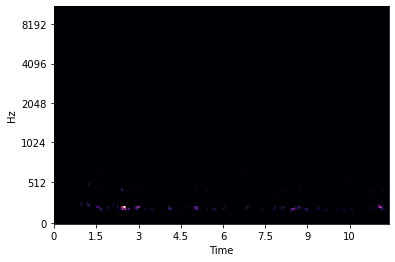

In [9]:
# Example spectrogram
duration_time = 11.88

y, sr = librosa.load('recordings/afrikaans1.wav', duration=duration_time) # can adjust duration, shape change
ex = librosa.feature.melspectrogram(y=y, sr=sr)
print(ex.shape)
librosa.display.specshow(ex, y_axis='mel', x_axis='time')

In [10]:
length = ex.shape[1]
# get the total sample size of new dataset (after removal)
numOfTotal = data.shape[0]

# subset of data, for testing (how many samples from dataset we use)
numOfSample = numOfTotal 

data = data[:numOfSample]
print("dataset dimension:", data.shape)
print("number of samples:", numOfSample)

dataset dimension: (2138, 10)
number of samples: 2138


In [57]:
D = [] # Dataset
spec = []

start = time.time()

for row in data.itertuples():
    y, sr = librosa.load(row.filePath, duration=duration_time)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (128, length): continue
    D.append( (ps, row.sex_female) )
    spec.append(ps)
    
end = time.time()    

print("Number of samples: ", len(D))
print("time used for generating spectrogram:", end-start)


Number of samples:  2138
time used for generating spectrogram: 1551.4360229969025


In [58]:
# save the converted spectrogram info dataframe into file
open_file = open('spectrogram_gender', "wb")
pickle.dump(D, open_file)
open_file.close()

open_file = open('spectrogram', "wb")
pickle.dump(spec, open_file)
open_file.close()

# start here!

### first try
ignore this. I wrongly used softmax as activation funciton with Dense(1)

In [ ]:
# load the spectrogram info datafram
# it actually just some big numerical arrays, librosa covert the spectrogram to some numerical info.

open_file = open('spectrogram_gender', "rb")
D = pickle.load(open_file)
open_file.close()

dataset = D

In [78]:
from keras import utils

# radomize the dataset
random.shuffle(dataset)

numSplit = round(numOfSample * 0.8)

# split training set and testing set
train = dataset[:numSplit]
test = dataset[numSplit:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, length, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, length, 1) ) for x in X_test])

# transform to np array
y_train = np.array(y_train)
y_test = np.array(y_test)

In [80]:
# set up neural network: layer, number of neuron, activation function, etc.
model = Sequential()
input_shape=(128, length, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(1))
model.add(Activation('softmax'))

In [64]:
import tensorflow as tf

In [81]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]


model.compile(
	optimizer="Adam",
	loss="binary_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=12,
    batch_size=1,
    callbacks=my_callbacks,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
1710/1710 [==============================] - 144s 83ms/step - loss: 1.1904 - accuracy: 0.4789 - val_loss: 0.7018 - val_accuracy: 0.5070
Epoch 2/12
1710/1710 [==============================] - 150s 88ms/step - loss: 0.5562 - accuracy: 0.4789 - val_loss: 0.5778 - val_accuracy: 0.5070
Epoch 3/12
1710/1710 [==============================] - 161s 94ms/step - loss: 0.4486 - accuracy: 0.4789 - val_loss: 0.4164 - val_accuracy: 0.5070
Epoch 4/12
1710/1710 [==============================] - 163s 95ms/step - loss: 0.3429 - accuracy: 0.4789 - val_loss: 0.3624 - val_accuracy: 0.5070
Epoch 5/12
1710/1710 [==============================] - 146s 86ms/step - loss: 0.2899 - accuracy: 0.4789 - val_loss: 0.2462 - val_accuracy: 0.5070
Epoch 6/12
1710/1710 [==============================] - 154s 90ms/step - loss: 0.2704 - accuracy: 0.4789 - val_loss: 0.6130 - val_accuracy: 0.5070
Epoch 7/12
1710/1710 [==============================] - 141s 82ms/step - loss: 0.2086 - accuracy: 0.4789 - val_loss: 0

### second try
change activaiton funciton from softmax to sigmoid

since the accuracy doesn't change, I also doubt about the learning rate is too low.

The default learning rate of optimizer="Adam" is 0.001. I tried rate = 0.01 first, and accuracy jumped pretty fast. Then I tried rate = 0.005, and it still jumped. Finally, I changed back to the orginal rate = 0.001 ==> Stable

In [82]:
# set up neural network: layer, number of neuron, activation function, etc.
model = Sequential()
input_shape=(128, length, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [84]:
import tensorflow as tf
from tensorflow import keras

In [87]:
opt = keras.optimizers.Adam(learning_rate=0.001)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]


model.compile(
	optimizer=opt,
	loss="binary_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=12,
    batch_size=1,
    callbacks=my_callbacks,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
1710/1710 [==============================] - 144s 84ms/step - loss: 0.7942 - accuracy: 0.5673 - val_loss: 0.6865 - val_accuracy: 0.5327
Epoch 2/12
1710/1710 [==============================] - 154s 90ms/step - loss: 0.6890 - accuracy: 0.6462 - val_loss: 0.6496 - val_accuracy: 0.6028
Epoch 3/12
1710/1710 [==============================] - 230s 134ms/step - loss: 0.6459 - accuracy: 0.6515 - val_loss: 0.4415 - val_accuracy: 0.8364
Epoch 4/12
1710/1710 [==============================] - 191s 112ms/step - loss: 0.5859 - accuracy: 0.7427 - val_loss: 0.6209 - val_accuracy: 0.6495
Epoch 5/12
1710/1710 [==============================] - 173s 101ms/step - loss: 0.4397 - accuracy: 0.8673 - val_loss: 0.2488 - val_accuracy: 0.9369
Epoch 6/12
1710/1710 [==============================] - 168s 98ms/step - loss: 0.3126 - accuracy: 0.9012 - val_loss: 0.2582 - val_accuracy: 0.9252
Epoch 7/12
1710/1710 [==============================] - 180s 105ms/step - loss: 0.3018 - accuracy: 0.9099 - val_los

## Explore the differences of visualized spectrogram between men & female
doesn't find anything

In [122]:
pdd = pd.DataFrame(dataset)
dataM = pdd.loc[pdd.loc[:][1] == 0]
dataF = pdd.loc[pdd.loc[:][1] == 1]
dataM


,0,1
4,"[[3.7719445e-09, 8.995782e-09, 6.7941164e-09, ...",0
5,"[[0.22899562, 0.4602557, 0.19079475, 0.2829420...",0
6,"[[1.3870534, 2.3736558, 2.0774436, 3.3120668, ...",0
8,"[[0.01770663, 0.034173228, 0.017504234, 0.0197...",0
9,"[[0.43467674, 0.48980445, 0.40332612, 0.397682...",0
...,...,...
2129,"[[3.989603e-09, 5.159455e-09, 2.2959836e-09, 6...",0
2130,"[[3.2677603e-09, 6.5180528e-09, 4.683986e-09, ...",0
2131,"[[0.0003151488, 0.010444802, 0.060265917, 0.10...",0
2135,"[[9.3888e-05, 0.00032636346, 0.00086883875, 0....",0


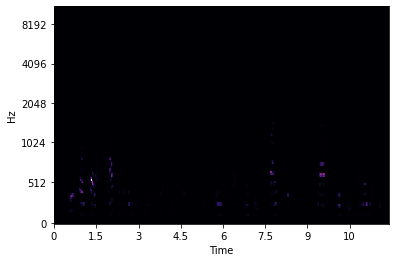

In [116]:
librosa.display.specshow(dataM.iloc[0][0], y_axis='mel', x_axis='time')

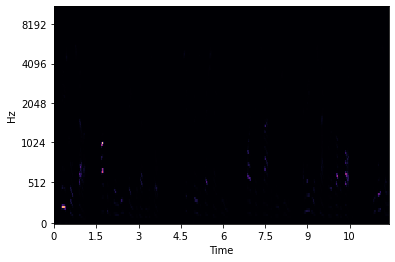

In [117]:
librosa.display.specshow(dataM.iloc[1][0], y_axis='mel', x_axis='time')

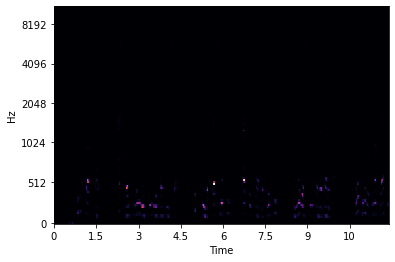

In [118]:
librosa.display.specshow(dataM.iloc[2][0], y_axis='mel', x_axis='time')

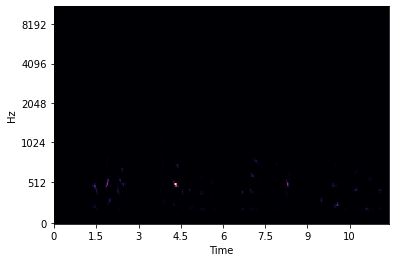

In [119]:
librosa.display.specshow(dataF.iloc[0][0], y_axis='mel', x_axis='time')

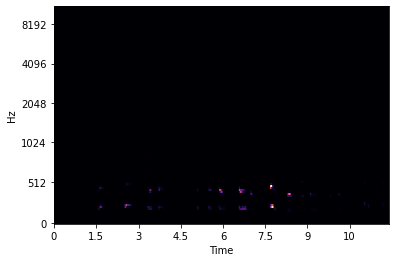

In [120]:
librosa.display.specshow(dataF.iloc[1][0], y_axis='mel', x_axis='time')

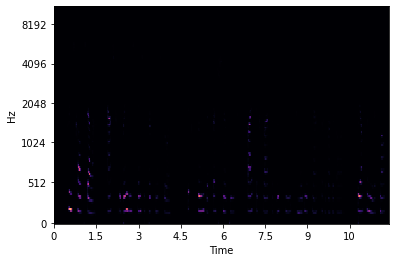

In [121]:
librosa.display.specshow(dataF.iloc[2][0], y_axis='mel', x_axis='time')

## Third attempt
change filter size form (5, 5) to (3, 3) ==> this speed up the training!

increse epochs from 12 to 20 since I apply callback function



In [123]:
# set up neural network: layer, number of neuron, activation function, etc.
model = Sequential()
input_shape=(128, length, 1)

model.add(Conv2D(24, (3, 3), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (3, 3), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (3, 3), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]


model.compile(
	optimizer=opt,
	loss="binary_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=20,
    batch_size=1,
    callbacks=my_callbacks,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
1710/1710 [==============================] - 127s 74ms/step - loss: 1.3896 - accuracy: 0.6620 - val_loss: 0.5205 - val_accuracy: 0.7804
Epoch 2/20
1710/1710 [==============================] - 138s 81ms/step - loss: 0.5774 - accuracy: 0.7602 - val_loss: 0.4048 - val_accuracy: 0.8435
Epoch 3/20
1710/1710 [==============================] - 154s 90ms/step - loss: 0.3301 - accuracy: 0.8749 - val_loss: 0.2201 - val_accuracy: 0.9533
Epoch 4/20
1710/1710 [==============================] - 118s 69ms/step - loss: 0.2712 - accuracy: 0.9140 - val_loss: 0.1449 - val_accuracy: 0.9556
Epoch 5/20
1710/1710 [==============================] - 103s 61ms/step - loss: 0.1978 - accuracy: 0.9450 - val_loss: 0.1349 - val_accuracy: 0.9603
Epoch 6/20
1710/1710 [==============================] - 104s 61ms/step - loss: 0.1925 - accuracy: 0.9450 - val_loss: 0.1322 - val_accuracy: 0.9486
Epoch 7/20
1710/1710 [==============================] - 100s 58ms/step - loss: 0.1685 - accuracy: 0.9485 - val_loss: 0

In [61]:
# save the converted spectrogram info dataframe into file
open_file = open('spectrogram_gender', "wb")
pickle.dump(D, open_file)
open_file.close()

In [ ]:
# load the spectrogram info datafram

# it actually just some big numerical arrays, librosa covert the spectrogram to some numerical info.

# open_file = open('spectrogram_gender', "rb")
# loaded_spectrogram = pickle.load(open_file)
# open_file.close()